In [1]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
D = 8 # Amount of documents
V = 12 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
M = 10 

k = 5 # Amount of topics
gamma = 0.2  # 0.05

In [2]:
# # GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
# D = 100 # Amount of documents
# V = 20 # Size of the vocabulary

# # (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# # To get the actual maximum amount, call Simulator.get_M
# M = 10 

# k = 10 # Amount of topics
# gamma = 0.05

## IMPORTANT: Please use static random seeds in **EVERY** cell where you use a random function, so that the result does **NOT** change at every run.

# 1. ARTIFICIAL DATA

### Task:

You must implement an algorithm that generates an artificial *corpus*, and return also a graph G and a correlation matrix Sigma.

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import bernoulli
#!pip install sklearn
from sklearn.datasets import make_sparse_spd_matrix
import matplotlib.pyplot as plt

In [4]:
# Transformation functions (deterministic)

def update_Theta(Theta, H, log=False):
    for d in range(D):
        Theta[d] = np.exp(H[d]) / np.sum(np.exp(H[d]), axis=0)
    if log:
        print('Success: Theta transformed from H')
    return Theta

def update_E(E, Z):
    k = E.shape[1]
    for topic in range(k):
        E[:, topic] = np.sum(Z == topic, axis=2).sum(axis=1)
    print('Success: E transformed from Z')
    return E

def update_C(C, Z):
    k = C.shape[0]
    for topic in range(k):
        C[topic, :] = np.sum(Z == topic, axis=2).sum(axis=0)
    print('Success: C transformed from Z')
    return C

def update_B(B, C):
    # Note this is the transformation from C
    for topic in range(0, len(B)):
        B[topic] = C[topic] / sum(C[topic])
    print('Success: B transformed from C')
    return B

def update_Sigma(K):
    Sigma = np.linalg.inv(K)
    print('Success: Sigma transformed from K')
    return Sigma

In [5]:
# Random / Generating functions

def build_topic_distribution(seed):
    np.random.seed(seed)
    distribution = np.random.random(V)
    return distribution / distribution.sum()

def sample_B(seed):
    # B is the matrix whose rows are the distribution of topic i over the vocabulary
    # Each row means : for each topic i we have the probability of word i to occur
    # TODO: Change with Dirichlet prior -> See line to change
    b = np.empty((k,V))
    np.random.seed(seed)
    for i in range(k):
        b[i,:] = build_topic_distribution(seed)  # TODO: Change
    return b

def sample_G(k, gamma, seed):  # Won't update Sigma automatically anymore
    # Bernoulli for G
    # generate a random adjacency matrix
    np.random.seed(seed)
    matrix = np.array([[int(bernoulli.rvs(p=gamma, size=1)) for i in range(k)] for j in range(k)])
    for i in range(k):
        matrix[i][i] = 0
    for i in range(k):
        for j in range(k):
            matrix[j][i] = matrix[i][j]
    return matrix

def sample_K(k, seed):  # Won't update Sigma automatically anymore
    # I can build K for using make_sparse_spd_matrix from sklearn.datasets for example
    np.random.seed(seed)
    K = make_sparse_spd_matrix(k, alpha=0.95, norm_diag=False, smallest_coef=0.1, largest_coef=0.9, random_state=None)
    return K

def sample_H(Sigma, D, k, seed):  # Won't update Theta automatically anymore
    # Multivariate Normal
    mu = np.zeros(k)
    np.random.seed(seed)
    H = np.random.multivariate_normal(mu, Sigma, D)
    return H

def sample_Z_from_W(W, k, seed):
    D, V = W.shape
    M = int(W.max())
    Z = -np.ones((D, V, M))
    np.random.seed(seed)
    for d in range(D):
        for w in range(V): 
            occurrences = W[d, w]
            Z[d, w, 0:occurrences] = np.random.randint(0, k, size=occurrences)    
    return Z

In [6]:
# Main Simulator Class
class Simulator:
    
    # Remember we will have indexes starting from 0 so all max are -=1
    
    def __init__(self, D, V, M, k, gamma, seed):
        # Create zero matrices for all possible matrices
        self.W = np.zeros((D, V))  # matrix of D×V where Wdn is counter of appearances of the word n in document d
        self.B = np.zeros((k, V))  # matrix of kxV where Bz is the parameter vector of the distribution for the z-th topic
        self.C = np.zeros((k, V))  # matrix of kxV where Cz is the count vec of sampled topics over each word for all docs
        self.E = np.zeros((D, k))  # matrix of Dxk where Ed is the count vec of sampled drawings for topic z over all words for each doc
        self.H = np.zeros((D, k))  # H_d is eta_d
        self.Theta = np.zeros((D, k))  # This is just a transformation of H
        self.G = np.zeros((k, k))  # Adjacency Matrix (Check also python package "networkx" for graph objects!)
        self.K = np.zeros((k, k))  # Precision matrix of G
        self.Sigma = np.zeros((k, k))  # Inverse of K
        self.Z = -np.ones((D, V, M))  # Topic assignments for each words of each document
        self.D = D
        self.V = V
        self.M = M
        self.k = k
        self.gamma = gamma
        self.seed = seed  # Random seed

    # Generations
    def generate_WZ(self):
        if M == 0:
            raise Exception('Error: M value is 0')
        elif np.sum(self.Theta, axis=1).sum(axis=0) == 0:
            raise Exception('Error: Theta matrix 0')
        elif np.sum(self.B, axis=1).sum(axis=0) == 0:
            raise Exception('Error: B matrix 0')
        
        np.random.seed(self.seed)
        # Ref https://numpy.org/doc/stable/reference/random/generated/numpy.random.multinomial.html
        # Multinomial drawing for Z and then W
        for d in range(self.D):
            
            # Maximum number of word drawings in the document            
            N_d = np.random.randint(1, int(self.M * self.V * 0.7))  # Hard-coding 70% thinning factor
            for n in range(N_d):
                
                # Multinomial drawing from Theta, because it has to be normalized
                # This will give a canonical vector over k
                mult = np.random.multinomial(1, self.Theta[d], size=1)  # This is a vector of 0's with a single 1
                z = np.argmax(mult)  # This is the index of the 1 (Topic index)
                
                # Multinomial drawing from Beta
                # This will give a canonical vector over V
                mult = np.random.multinomial(1, self.B[z], size=1)  # This is a vector of 0's with a single 1
                w = np.argmax(mult)  # This is the index of the 1 (Word index)
                
                empty_cell_indexes = np.nonzero(self.Z[d, w] == -1)[0]  # Check if there are still possible unassigned occurrences for this word
                if empty_cell_indexes.size != 0:  # At least one entry is not assigned
                    first_empty_index = empty_cell_indexes[0]
                    self.Z[d, w, first_empty_index] = z  # Assinging word to topic
                    self.W[d, w] += 1  # Increasing word counter
        
        print('Success: W and Z generated')
    
    # Transformations
    def update_Theta(self):
        self.Theta = update_Theta(self.Theta, self.H)
    
    def update_E(self):
        self.E = update_E(self.E, self.Z)
    
    def update_C(self):
        self.C = update_C(self.C, self.Z)
    
    def update_Sigma(self):
        self.Sigma = update_Sigma(self.K)
    
    # Initializing with real data
    # def save_W()
    
    # Priors
    def sample_B(self):
        self.B = sample_B(self.seed)
        
    def sample_GK(self):  # Here we can update Sigma automatically
        self.G = sample_G(self.k, self.gamma, self.seed)
        self.K = sample_K(self.k, self.seed)
        self.update_Sigma()
    
    def sample_H(self):  # Here we can update Theta automatically
        self.H = sample_H(self.Sigma, self.D, self.k, self.seed)
        self.update_Theta()
    
    def generate_all_data(self):
        # TODO: This should run all relevant methods one after the other in order to fully populate all data matrixes
        self.sample_B()  # Will get B
        self.sample_GK()  # Will get G, K, Sigma
        self.sample_H()  # Will get H, Theta from Sigma
        self.generate_WZ()  # Will get W, Z from Theta, B
        self.update_E()  # Will get E from Z
        self.update_C()  # Will get C from Z
        pass

## 1.1 Simulator Tests

In [7]:
test0 = Simulator(D, V, M, k, gamma, seed=1996)
test0.sample_GK()  # Will get G, K, Sigma
test0.sample_H()  # Will get H, Theta from Sigma
test0.sample_B()  # Will get B
test0.generate_WZ()
test0.update_E()

Success: Sigma transformed from K
Success: W and Z generated
Success: E transformed from Z


In [8]:
test0.W

# NOTE:
# With M*D it's not really respected that M is the real max, just a desired one
# With 70% of that it's still not respected but closer
# With 50% of that it's respected in this case -> Could check if we can have real max M at some point

array([[ 3.,  2.,  4.,  5.,  1.,  6.,  7.,  9., 10.,  6.,  4.,  0.],
       [ 7.,  0.,  2.,  1.,  1.,  2.,  1.,  1.,  3.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 7.,  1.,  2., 10.,  1.,  5., 10.,  7., 10.,  8.,  2.,  2.],
       [ 1.,  0.,  4.,  2.,  0.,  1.,  1.,  2.,  2.,  0.,  0.,  0.],
       [ 3.,  1.,  4.,  8.,  2.,  4.,  5., 10.,  5.,  8.,  4.,  1.],
       [ 0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  3.,  0.,  0.,  0.],
       [ 7.,  1.,  3.,  8.,  0.,  3.,  4.,  3.,  2., 10.,  3.,  0.]])

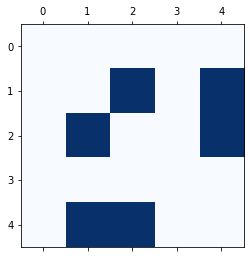

In [9]:
# NOTE You can simply use mathshow to plot matrices:
plt.matshow(test0.G, cmap='Blues')

In [10]:
# All in one function
test1 = Simulator(D, V, M, k, gamma, seed=1979)
test1.generate_all_data()
test1.W

Success: Sigma transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


array([[ 1.,  1.,  2.,  0.,  0.,  2.,  2.,  1.,  1.,  1.,  0.,  3.],
       [ 8.,  4., 10.,  1.,  8.,  2.,  4.,  7.,  4.,  6.,  1.,  9.],
       [ 2.,  4.,  2.,  0.,  0.,  0.,  2.,  1.,  1.,  3.,  0.,  1.],
       [ 6.,  6.,  3.,  1.,  4.,  2.,  1.,  5.,  1.,  5.,  2., 10.],
       [ 6.,  9.,  3.,  2.,  4.,  1.,  2.,  9.,  4.,  5.,  1.,  8.],
       [ 5.,  5.,  5.,  0.,  7.,  1.,  4.,  8.,  4.,  3.,  1.,  3.],
       [ 5.,  5.,  3.,  2.,  8.,  3.,  2.,  5.,  6.,  0.,  0.,  7.],
       [ 5.,  1.,  1.,  0.,  0.,  0.,  1.,  6.,  1.,  4.,  1.,  4.]])

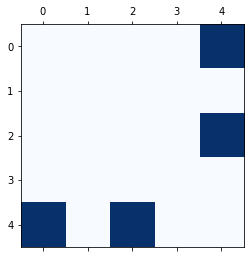

In [11]:
# NOTE You can simply use mathshow to plot matrices:
plt.matshow(test1.G, cmap='Blues')

In [12]:
# Confirming that with the same seed and input parameters, data generated are the same
test2 = Simulator(D, V, M, k, gamma, seed=1979)
test2.generate_all_data()
assert np.all(np.equal(test1.W, test2.W))  

Success: Sigma transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


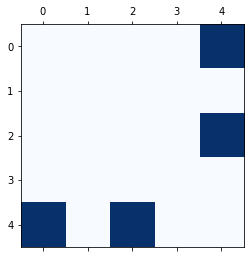

In [13]:
# NOTE You can simply use mathshow to plot matrices:
plt.matshow(test2.G, cmap='Blues')

From now on let's use the following simulated data for further testing

In [14]:
test_data = Simulator(D, V, M, k, gamma, seed=1967)  # Man on the moon
test_data.generate_all_data()

random_initial_data = Simulator(D, V, M, k, gamma, seed=1969)  # Woodstock Music Festival
random_initial_data.generate_all_data()

# Problem: We need at least matching Ws (?)
# Shouldn't we generate the random initial data starting from W?
# random_initial_data.W = test_data.W
# random_initial_data.Z = sample_Z_from_W(test_data.W, k, seed=1969)
# ...

Success: Sigma transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z
Success: Sigma transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


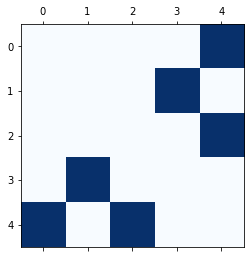

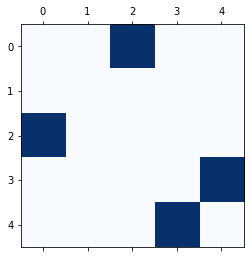

In [15]:
plt.matshow(test_data.G, cmap='Blues')

plt.matshow(random_initial_data.G, cmap='Blues')

# 2 MC SAMPLER

## 2.1.1 MCMC Sampling

### Task:

You must implement a function that receives matrices $W$, $\Theta_{i+1}$ and $B_i$ and generates the next $Z_{i+1}$ and $B_{i+1}$.

In [16]:
def binary_search(sequence, item):
    begin_index = 0
    end_index = len(sequence)-1
    
    if sequence[begin_index] <= item and item <= sequence[end_index]:
        while begin_index < end_index - 1:  # Finish when the list has 2 items: Begin and end
            midpoint = (end_index + begin_index) // 2
            midpoint_value = sequence[midpoint]
            if midpoint_value < item:
                begin_index = midpoint
            else:
                end_index = midpoint
        if sequence[begin_index] == item:
            return begin_index + 1
        elif item <= sequence[end_index]:
            return end_index
    else:
        return -1

In [17]:
def MC_sample_Z(Z, W, Theta, B, E, C):  # D, k are global variables
    for d in range(D):
        for v in range(V):
            I_di = int(W[d, v])
            for j in range(I_di):
                z_hat = int(Z[d, v, j])
                
                if z_hat != -1:  # Bug fix: Took invalid topics and assigned them
                
                    E[d, z_hat] = max(0, E[d, z_hat]-1)

                    C[z_hat, v] = max(0, C[z_hat, v]-1)

                    Rho = []  # Needs to start from zero to have the interval to fall into topic 1
                    Rho_z = 0
                    #Rho.append(Rho_z)

                    for z in range(k):
                        # Compute the denominator sum
                        C_vk = 0
                        for b in range(V):
                            if b != v:
                                C_vk += C[z, b]
                        # Compute the upper limits of the topic probabilities
                        d_part = E[d, z] + Theta[d, z]
                        z_part = C[z, v] + B[z, v]
                        denom = C_vk + V * B[z, v]
                        Rho_z = d_part * z_part / denom
                        Rho.append(Rho_z)
                        
                    Rho = Rho / np.sum(Rho, axis=0)

                    #print('Old topic: '+str(z_hat)+' search in: '+str(Rho))

                    #u = np.random.uniform(0, Rho[-1])
                    #z_hat = binary_search(Rho, u) - 1
                    
                    z_hat = np.random.choice(k, 1, p=Rho)

                    E[d, z_hat] += 1
                    C[z_hat, v] += 1
                    Z[d, v, j] = z_hat

                    #print('New topic: '+str(z_hat)+', counter by doc: '+str(E[d, z_hat])+', counter by topic: '+str(C[z_hat, v]))

    # Note that we directly modify Z since the update per topic helps for the next iteration 
    return Z, E, C

## 2.1.2 MCMC Sampling Tests

In [18]:
Z_copy = random_initial_data.Z.copy()

W_copy = test_data.W.copy()
Theta_copy = test_data.Theta.copy()
B_copy = test_data.B.copy()
E_copy = test_data.E.copy()
C_copy = test_data.C.copy()

Z_copy[0]  # Example

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 0.,  1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

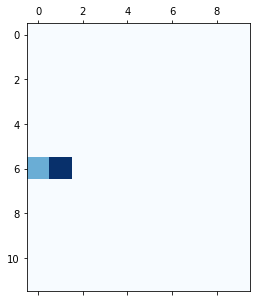

In [19]:
plt.matshow(Z_copy[0], cmap='Blues')

In [20]:
# Check that the function runs with no issues, without side effects but on Z

Z_sample, E_sample, C_sample = MC_sample_Z(Z_copy, W_copy, Theta_copy, B_copy, E_copy, C_copy)

assert np.any(Z_copy != random_initial_data.Z)
assert np.all(W_copy == test_data.W)
assert np.all(Theta_copy == test_data.Theta)
assert np.all(B_copy == test_data.B)

# TODO: Review! Should these matrix change? -> Yes since Z is modified
# BUG https://trello.com/c/pWZCzOxq/29-mcsamplez-e-and-c-are-modified
# assert np.all(E_sample == test_data.E) # Triggers
# assert np.all(C_sample == test_data.C) # Triggers

Z_sample[0]

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1.,  0., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

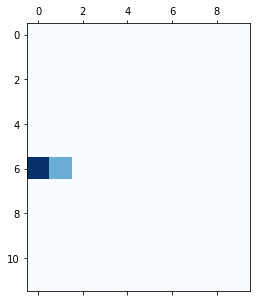

In [21]:
plt.matshow(Z_sample[0], cmap='Blues')

In [22]:
%%time
# Check that the Sampler works properly (This will take a while)
errors = []
E_errors = []
C_errors = []
matrix_changes = []
burn_in = 1000
print(f'The sampled Z has {Z_sample.size} words, while the target Z has {test_data.Z.size} words (diff {abs(Z_sample.size-test_data.Z.size)})')
for i in range(5000):
    Z_sample_old = Z_sample.copy()
    E_sample_old = E_sample.copy()
    C_sample_old = C_sample.copy()
    Z_sample, E_sample, C_sample = MC_sample_Z(Z_sample, W_copy, Theta_copy, B_copy, E_sample, C_sample)
    matrix_changes.append(~np.all(Z_sample_old == Z_sample))
    if i >= burn_in:
        errors.append(np.linalg.norm(Z_sample - test_data.Z))  # Computing error wrt the target distribution
        E_errors.append(np.linalg.norm(E_sample - test_data.E))        
        C_errors.append(np.linalg.norm(C_sample - test_data.C))

The sampled Z has 960 words, while the target Z has 960 words (diff 0)
Wall time: 3min 11s


Matrix changes (1 = changed, 0 = same)
count    5000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

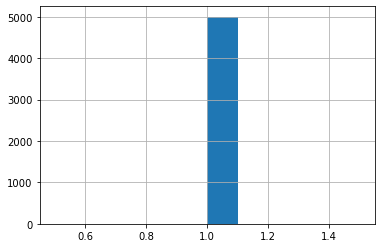

In [23]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

Z error metrics
count    4000.000000
mean       65.784976
std         0.394278
min        64.428255
25%        65.513357
50%        65.772335
75%        66.037868
max        67.216070
dtype: float64


Text(0.5, 1.0, 'Z L2-error distribution')

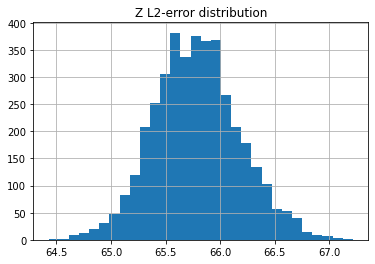

In [24]:
# Error should be distributed close to 0 (I guess...)
# BUG https://trello.com/c/JE1T7Hur/31-mcsamplez-z-is-not-close-to-the-expected-target
errors = pd.Series(errors)
print("Z error metrics")
print(errors.describe())
errors.hist(bins=30)
plt.title('Z L2-error distribution')

Text(0.5, 1.0, 'Z L2-error series')

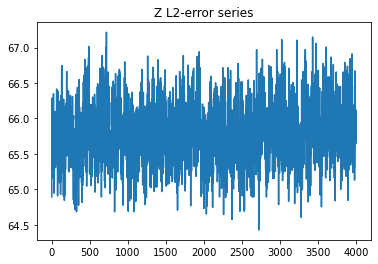

In [25]:
errors.plot()
plt.title('Z L2-error series')

E error metrics
count    4000.000000
mean       39.393228
std         2.467710
min        31.543621
25%        37.775654
50%        39.230090
75%        40.951190
max        48.754487
dtype: float64


Text(0.5, 1.0, 'E L2-error distribution')

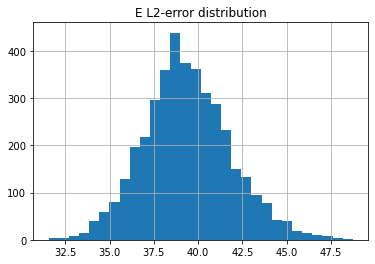

In [26]:
# Error should be distributed close to 0 (I guess...)
# BUG https://trello.com/c/JE1T7Hur/31-mcsamplez-z-is-not-close-to-the-expected-target
E_errors = pd.Series(E_errors)
print("E error metrics")
print(E_errors.describe())
E_errors.hist(bins=30)
plt.title('E L2-error distribution')

Text(0.5, 1.0, 'E L2-error series')

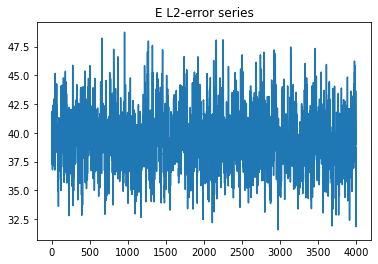

In [27]:
E_errors.plot()
plt.title('E L2-error series')

C error metrics
count    4000.000000
mean       32.281932
std         2.628609
min        22.538855
25%        30.659419
50%        32.403703
75%        34.117444
max        41.785165
dtype: float64


Text(0.5, 1.0, 'C L2-error distribution')

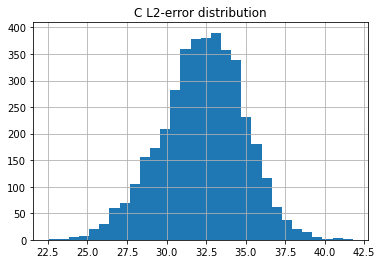

In [28]:
# Error should be distributed close to 0 (I guess...)
# BUG https://trello.com/c/JE1T7Hur/31-mcsamplez-z-is-not-close-to-the-expected-target
C_errors = pd.Series(C_errors)
print("C error metrics")
print(C_errors.describe())
C_errors.hist(bins=30)
plt.title('C L2-error distribution')

Text(0.5, 1.0, 'C L2-error series')

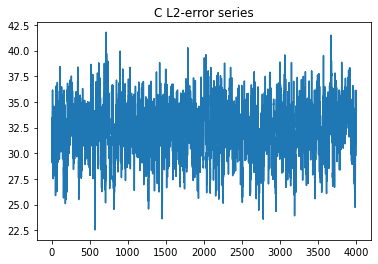

In [29]:
C_errors.plot()
plt.title('C L2-error series')

In [55]:
# Binder loss function (FA revised)
# Sum for i < j -> 1 error for each pair that is equal in one and different in the other

def binder_loss(Z_sample, Z_true, debug=False):
    # Input: Z_sample, Z_true matrices -> We only need the cluster indexes
    # Output: err scalar -> Sum of errors
    if Z_sample.shape != Z_true.shape:
        raise Exception('Error: Z matrices of different shape')
    # Idea: Turn matrices into single row to check all pairs more easily
    # First element checks all next elements
    # Get all possible pairs without repeating
    errors = np.zeros((k, k))
    for t_sample in range(k):  # iterate over sample topics
        Z_sample_indicator = Z_sample == t_sample
        Z_sample_indicator = Z_sample_indicator.flatten()
        # Idea: Matrix of differences between rows
        # https://stackoverflow.com/questions/9704565/populate-numpy-matrix-from-the-difference-of-two-vectors
        Z_sample_indicator = np.bitwise_xor.outer(Z_sample_indicator, Z_sample_indicator)
        # xor if they are different
        #Z_sample_indicator = np.abs(Z_sample_indicator)
        for t_true in range(k):  # iterate over true topics
            # See only equals -> absolute of the difference
            # Eq + Eq -> abs(1-1) = 0 no error
            # Eq + Diff or Diff + Eq -> abs(1-0) = abs(0-1) = 1 error
            # Diff + Diff -> abs(0-0) = 0 no error
            Z_true_indicator = Z_true == t_true
            Z_true_indicator = Z_true_indicator.flatten()
            Z_true_indicator = np.bitwise_xor.outer(Z_true_indicator, Z_true_indicator)
            #Z_true_indicator = np.abs(Z_true_indicator)
            #print('Size sample: '+str(Z_sample_indicator.size)+', true:'+str(Z_true_indicator.size))
            # Now we have the pairwise differences to compare
            error_sum = np.not_equal(Z_sample_indicator, Z_true_indicator).sum() 
            errors[t_sample][t_true] = error_sum/2  # We take the entire matrix so the errors are duplicated
            
    if debug:
        print('Error matrix:')
        print(errors)
        print('Error sum:')
        print(errors.sum())
    # Minimization (Stable Marriage Problem)
    final_loss = 0
    matches = []
    theoretical_max = 10000000#Z_sample.size  # I will use it as a dummy variable
    for pair in range(k):
        min_error = np.amin(errors.flatten())  # Select min
        i, j = np.where(errors == min_error)  # Find index
        # There could be multiple minima, only using the first one
        i = i[0]
        j = j[0]
        if debug:
            print(f"Sample topic {i} was matched with true topic {j} with error {min_error}")
        final_loss += min_error
        matches.append([i, j])
        # Filling corresponding row and column so that those two indexes will not be selected again
        errors[:,j] = theoretical_max
        errors[i,:] = theoretical_max
    return final_loss

In [56]:
%%time
# Testing
binder_loss(Z_sample, test_data.Z, debug=True)  # Note that all possible pairs are 460320

Error matrix:
[[ 91271. 118175.  94239.  92759. 129911.]
 [102951. 109991.  91271.  86759. 127359.]
 [ 98631. 111375.  79079.  85239. 122159.]
 [107900. 117504.  93500.  81404. 116156.]
 [140400. 152000. 134300. 126716. 124124.]]
Error sum:
2735173.0
Sample topic 2 was matched with true topic 2 with error 79079.0
Sample topic 3 was matched with true topic 3 with error 81404.0
Sample topic 0 was matched with true topic 0 with error 91271.0
Sample topic 1 was matched with true topic 1 with error 109991.0
Sample topic 4 was matched with true topic 4 with error 124124.0
Wall time: 182 ms


485869.0

In [57]:
%%time
# This MUST return zero
binder_loss(Z_sample, Z_sample, debug=True)

Error matrix:
[[     0. 110684. 102236. 116831. 152559.]
 [110684.      0. 100800. 115479. 151439.]
 [102236. 100800.      0. 107199. 144551.]
 [116831. 115479. 107199.      0. 156416.]
 [152559. 151439. 144551. 156416.      0.]]
Error sum:
2516388.0
Sample topic 0 was matched with true topic 0 with error 0.0
Sample topic 1 was matched with true topic 1 with error 0.0
Sample topic 2 was matched with true topic 2 with error 0.0
Sample topic 3 was matched with true topic 3 with error 0.0
Sample topic 4 was matched with true topic 4 with error 0.0
Wall time: 168 ms


0.0

In [58]:
# Shifting indexes
Z_sample_shifted = Z_sample.copy()
for i in range(k):
    replace_value = (i + 1) % k 
    Z_sample_shifted[Z_sample == i] = replace_value

# This MUST return zero
%time binder_loss(Z_sample, Z_sample_shifted, debug=True)

Error matrix:
[[152559.      0. 110684. 102236. 116831.]
 [151439. 110684.      0. 100800. 115479.]
 [144551. 102236. 100800.      0. 107199.]
 [156416. 116831. 115479. 107199.      0.]
 [     0. 152559. 151439. 144551. 156416.]]
Error sum:
2516388.0
Sample topic 0 was matched with true topic 1 with error 0.0
Sample topic 1 was matched with true topic 2 with error 0.0
Sample topic 2 was matched with true topic 3 with error 0.0
Sample topic 3 was matched with true topic 4 with error 0.0
Sample topic 4 was matched with true topic 0 with error 0.0
Wall time: 178 ms


0.0

In [59]:
%%time
# Check that the Sampler works properly (This will take forever)
errors = []

burn_in = 500
for i in range(2000):
    Z_sample_old = Z_sample.copy()
    E_sample_old = E_sample.copy()
    Z_sample, E_sample, C_sample = MC_sample_Z(Z_sample, W_copy, Theta_copy, B_copy, E_sample, C_sample)
    if i >= burn_in:
        # Around 30 seconds each 50 iterations -> 15 MINUTES FOR 1500 COMPUTATIONS
        errors.append(binder_loss(Z_sample, test_data.Z))  # Computing Binder loss

Wall time: 3min 38s


Error metrics
count      1500.000000
mean     492330.770667
std       11210.441458
min      464123.000000
25%      483420.500000
50%      492170.000000
75%      501287.000000
max      534783.000000
dtype: float64


<AxesSubplot:>

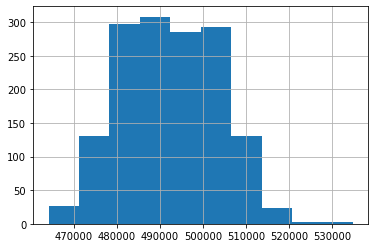

In [60]:
# Error will always be positive and integer, but is it skewed to the left?
errors = pd.Series(errors)
print("Error metrics")
print(errors.describe())
errors.hist()

<AxesSubplot:>

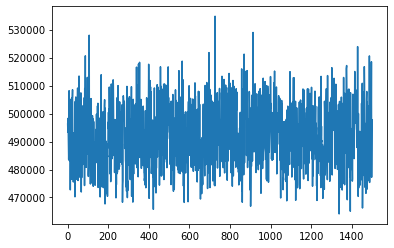

In [61]:
errors.plot()  # See if we still have a caterpillar

In [37]:
def binder_loss_fast(Z_sample, Z_true, debug=False):
    # Input: Z_sample, Z_true matrices -> We only need the cluster indexes
    # Output: err scalar -> Sum of errors
    if Z_sample.shape != Z_true.shape:
        raise Exception('Error: Z matrices of different shape')
    # Idea: Turn matrices into single row to check all pairs more easily
    # First element checks all next elements
    # Get all possible pairs without repeating
    errors = np.zeros((k, k))
    for t_sample in range(k):  # iterate over sample topics
        Z_sample_indicator = Z_sample == t_sample
        for t_true in range(k):  # iterate over true topics
            # See only equals -> absolute of the difference
            # Eq + Eq -> abs(1-1) = 0 no error
            # Eq + Diff or Diff + Eq -> abs(1-0) = abs(0-1) = 1 error
            # Dif + Diff -> abs(0-0) = 0 no error
            Z_true_indicator = Z_true == t_true
            error_sum = np.not_equal(Z_sample_indicator, Z_true_indicator).sum() 
            errors[t_sample][t_true] = error_sum
            
    if debug:
        print('Error matrix:')
        print(errors)
        print('Error sum:')
        print(errors.sum())
    # Minimization (Stable Marriage Problem)
    final_loss = 0
    matches = []
    theoretical_max = Z_sample.size  # I will use it as a dummy variable
    while not len(matches) == k:
        min_error = np.amin(errors.flatten())  # Select min
        i, j = np.where(errors == min_error)  # Find index
        # There could be multiple minima, only using the first one
        i = i[0]
        j = j[0]
        if debug:
            print(f"Sample topic {i} was matched with true topic {j} with error {min_error}")
        final_loss += min_error
        matches.append([i, j])
        # Filling corresponding row and column so that those two indexes will not be selected again
        errors[:,j] = theoretical_max
        errors[i,:] = theoretical_max
    return final_loss

In [38]:
%%time
# This MUST return zero
r = binder_loss_fast(Z_sample, Z_sample, debug=True)
r

Error matrix:
[[  0. 134. 140. 149. 201.]
 [134.   0. 122. 131. 183.]
 [140. 122.   0. 137. 189.]
 [149. 131. 137.   0. 198.]
 [201. 183. 189. 198.   0.]]
Error sum:
3168.0
Sample topic 0 was matched with true topic 0 with error 0.0
Sample topic 1 was matched with true topic 1 with error 0.0
Sample topic 2 was matched with true topic 2 with error 0.0
Sample topic 3 was matched with true topic 3 with error 0.0
Sample topic 4 was matched with true topic 4 with error 0.0
Wall time: 6.01 ms


0.0

In [39]:
# Shifting indexes
Z_sample_shifted = Z_sample.copy()
for i in range(k):
    replace_value = (i + 1) % k 
    Z_sample_shifted[Z_sample == i] = replace_value

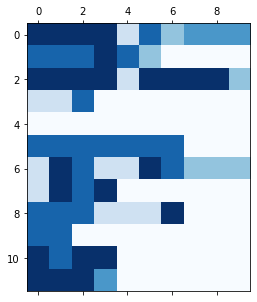

In [40]:
plt.matshow(Z_sample[2], cmap='Blues')

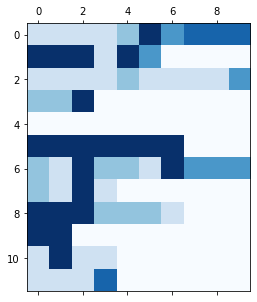

In [41]:
plt.matshow(Z_sample_shifted[2], cmap='Blues')

In [42]:
%%time
# This MUST return zero
r = binder_loss_fast(Z_sample, Z_sample_shifted, debug=True)
r

Error matrix:
[[201.   0. 134. 140. 149.]
 [183. 134.   0. 122. 131.]
 [189. 140. 122.   0. 137.]
 [198. 149. 131. 137.   0.]
 [  0. 201. 183. 189. 198.]]
Error sum:
3168.0
Sample topic 0 was matched with true topic 1 with error 0.0
Sample topic 1 was matched with true topic 2 with error 0.0
Sample topic 2 was matched with true topic 3 with error 0.0
Sample topic 3 was matched with true topic 4 with error 0.0
Sample topic 4 was matched with true topic 0 with error 0.0
Wall time: 4 ms


0.0

In [43]:
%%time
binder_loss_fast(Z_sample, test_data.Z, debug=True)

Error matrix:
[[121. 151. 111. 111. 165.]
 [117. 125. 107.  99. 151.]
 [113. 145.  99. 107. 159.]
 [128. 138. 108.  98. 142.]
 [178. 198. 164. 146. 152.]]
Error sum:
3333.0
Sample topic 3 was matched with true topic 3 with error 98.0
Sample topic 2 was matched with true topic 2 with error 99.0
Sample topic 1 was matched with true topic 0 with error 117.0
Sample topic 0 was matched with true topic 1 with error 151.0
Sample topic 4 was matched with true topic 4 with error 152.0
Wall time: 5 ms


617.0

In [44]:
binder_loss(Z_sample[1], test_data.Z[1])

716.0

In [45]:
binder_loss_fast(Z_sample[1], test_data.Z[1], debug=True)

Error matrix:
[[16. 10. 14.  6. 11.]
 [14.  6. 16.  6. 11.]
 [14. 12. 16.  8. 13.]
 [12.  6. 14.  2.  9.]
 [16. 12. 14.  8. 13.]]
Error sum:
279.0
Sample topic 3 was matched with true topic 3 with error 2.0
Sample topic 1 was matched with true topic 1 with error 6.0
Sample topic 0 was matched with true topic 4 with error 11.0
Sample topic 2 was matched with true topic 0 with error 14.0
Sample topic 4 was matched with true topic 2 with error 14.0


47.0

In [46]:
%%time
# Check that the Sampler works properly
errors = []

burn_in = 1000
for i in range(5000):
    Z_sample_old = Z_sample.copy()
    E_sample_old = E_sample.copy()
    Z_sample, E_sample, C_sample = MC_sample_Z(Z_sample, W_copy, Theta_copy, B_copy, E_sample, C_sample)
    if i >= burn_in:
        errors.append(binder_loss_fast(Z_sample, test_data.Z))  # Computing Binder loss

Wall time: 2min 54s


Z error metrics
count    4000.00000
mean      588.34300
std        16.03024
min       541.00000
25%       575.00000
50%       589.00000
75%       601.00000
max       659.00000
dtype: float64


Text(0.5, 1.0, 'Z Binder-fast-error distribution')

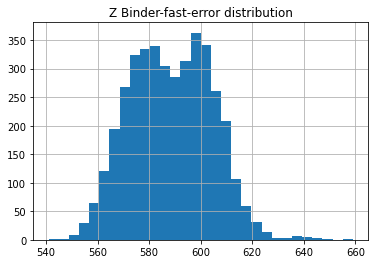

In [47]:
# Error will always be positive and integer, but is it skewed to the left?
errors = pd.Series(errors)
print("Z error metrics")
print(errors.describe())
errors.hist(bins=30)
plt.title('Z Binder-fast-error distribution')

Text(0.5, 1.0, 'Z Binder-fast-error series')

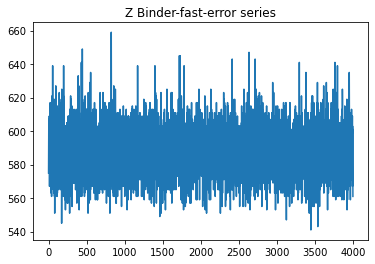

In [48]:
errors.plot()  # See if we still have a caterpillar
plt.title('Z Binder-fast-error series')

In [49]:
# Binder loss (Giulia)
def binder_loss_alt(Z_sample, Z_true, debug=False):
    # Fill here
    return final_loss

In [50]:
# Testing

In [51]:
%%time
# Check that the Sampler works properly
errors = []

burn_in = 1000
for i in range(5000):
    Z_sample_old = Z_sample.copy()
    E_sample_old = E_sample.copy()
    Z_sample, E_sample, C_sample = MC_sample_Z(Z_sample, W_copy, Theta_copy, B_copy, E_sample, C_sample)
    if i >= burn_in:
        errors.append(binder_loss_alt(Z_sample, test_data.Z))  # Computing Binder loss

NameError: name 'final_loss' is not defined

In [ ]:
# Error will always be positive and integer, but is it skewed to the left?
errors = pd.Series(errors)
print("Z error metrics")
print(errors.describe())
errors.hist(bins=30)
plt.title('Z Binder-alt-error distribution')

In [ ]:
errors.plot()  # See if we still have a caterpillar
plt.title('Z Binder-alt-error series')

## 2.2.1 Beta sampling

### Task:

You must implement a function that receives matrices $C_i$ and vector $\alpha$ and generates the next $B_{i+1}$.

In [62]:
def MC_sample_B(alpha, C):
    # B, C are (k, V) -> Generate k vectors
    B = np.random.dirichlet(alpha + C[0,:], size=1)  # Topic 0
    for i in range(C.shape[0]-1):  # Go through topics: Fix is excluding topic 0 already generated
        B = np.concatenate((B, np.random.dirichlet(alpha + C[i+1,:], size=1)), axis=0)
    return B

## 2.2.2 Beta sampling tests

In [63]:
# Check that the function runs with no issues, without side effects
alpha = np.ones(V)
C_copy = test_data.C.copy()

B_sample = MC_sample_B(alpha, C_copy)

assert np.all(C_copy == test_data.C)

In [64]:
B_sample.shape  # k, V -> Fixed

(5, 12)

In [66]:
%%time
# Check that the Sampler works properly (This will take a while)
errors = []
matrix_changes = []
burn_in = 1000
print(f'The sampled B has {B_sample.size} words, while the target B has {test_data.B.size} words (diff {abs(B_sample.size-test_data.B.size)})')
for i in range(5000):
    B_sample_old = B_sample.copy()
    B_sample = MC_sample_B(alpha, C_copy)
    matrix_changes.append(~np.all(B_sample_old == B_sample))
    if i >= burn_in:
        err_by_it = []
        for topic in range(k):
            err_by_it.append(np.linalg.norm(B_sample[topic] - test_data.B[topic]))  # Computing error wrt the target distribution  # BUG https://trello.com/c/uEYV7fSC/32-mcsampleb-shape-mismatch
        errors.append(err_by_it)

The sampled B has 60 words, while the target B has 60 words (diff 0)
CPU times: user 957 ms, sys: 39.4 ms, total: 996 ms
Wall time: 1 s


Matrix changes (1 = changed, 0 = same)
count    5000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

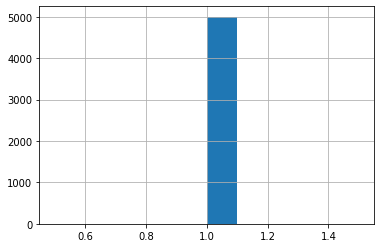

In [67]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

B L2-error metrics
                 0            1            2            3            4
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000
mean      0.125786     0.095724     0.161984     0.142733     0.188411
std       0.027048     0.018558     0.032080     0.027218     0.031964
min       0.046260     0.038586     0.062631     0.063571     0.082112
25%       0.106942     0.082755     0.139950     0.124139     0.167087
50%       0.124195     0.095142     0.160764     0.141771     0.186724
75%       0.143462     0.108191     0.182476     0.160321     0.209760
max       0.244832     0.171952     0.292934     0.248283     0.353935


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>, <AxesSubplot:>]], dtype=object)

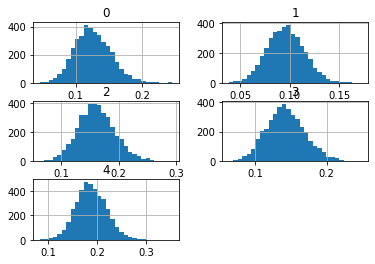

In [73]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/JE1T7Hur/31-mcsamplez-z-is-not-close-to-the-expected-target
errors = pd.DataFrame(errors)
print("B L2-error metrics")
print(errors.describe())
errors.hist(bins=30, layout=(3,2))

Text(0.5, 1.0, 'B L2-error series')

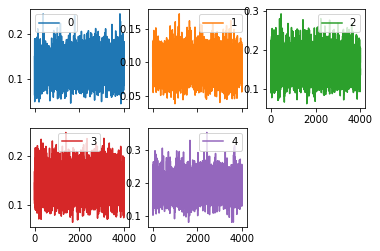

In [71]:
errors.plot(subplots=True, layout=(3,2))
plt.title('B L2-error series')

## 2.3.1 Metropolis-Hastings MC Sampling

### Task:

You must implement a function that receives matrices $E_i$, $K_i$ and vector $\mu$ and generates the next $H_{i+1}$.


. $E$ matrix of $D \times k$ where $E_d$ is the $k$-dim vector of counts of sampled drawings for the $z$-th topic over all words for each document

. $K$ matrix of $k \times k$ representing the precision matrix associated to the graph $G$

. $\mu = 0$

. $H$ matrix of $D \times k$ where $H_d = \eta_d$ is the $k$-dim vector of the topic prevalences over document $d$

In [224]:
import numpy as np
import numpy.linalg

In [225]:
def sampled_distribution_kernel(eta, K, E):
    k = eta.shape[0]
    eta_K_eta = -0.5 * eta.dot(K.dot(eta))
    E_eta = E.dot(eta)
    sum_eta_pow_k = np.sum(np.exp(eta)) ** k
    return np.exp(eta_K_eta + E_eta) / sum_eta_pow_k  # This np.exp raises a warning when  eta_K_eta + E_eta > 706

In [226]:
def MC_sample_H(E, Sigma, H_current=None, burn_in=100, seed=None):
    
    np.random.seed(seed)
    
    K = np.linalg.inv(Sigma)
    
    D, k = E.shape  # Number of documents, Number of topics
    
    if H_current is None:
        H_current = np.zeros((D, k))
    
    H_sampled = np.zeros((D, k))
    
    for d in range(D):  # Iterating over each document
        current_eta = H_current[d]
        E_d = E[d]
        for iteration in range(burn_in + 1):
            
            # Sampling proposed eta from multivariate normal (q "proposal density")
            proposed_eta = np.random.multivariate_normal(current_eta, Sigma)
            
            # Compute acceptance probability
            p_proposed_eta = sampled_distribution_kernel(proposed_eta, K, E_d)
            p_current_eta = sampled_distribution_kernel(current_eta, K, E_d)
            if p_proposed_eta == np.inf or p_current_eta == 0:  # Avoiding divide by 0 and other numerical creeps
                alpha = 1
            else:
                alpha = min(1, p_proposed_eta / p_current_eta)
            
            if alpha == 1 or np.random.uniform(0.0, 1.0) < alpha:
                current_eta = proposed_eta
            
        H_sampled[d] = current_eta
    
    return H_sampled

## 2.3.2 MH Sampling Tests

In [227]:
E_copy = test_data.E.copy()
Sigma_copy = test_data.Sigma.copy()

H_sample = MC_sample_H(E_copy, Sigma_copy)

assert np.all(E_copy == test_data.E)
assert np.all(Sigma_copy == test_data.Sigma)

/tmp/ipykernel_39721/2545393832.py:6: RuntimeWarning: overflow encountered in exp
  return np.exp(eta_K_eta + E_eta) / sum_eta_pow_k  # This np.exp raises a warning when  eta_K_eta + E_eta > 706


In [228]:
%%time
# Check that the Sampler works properly (This will take... forever)
errors = []
matrix_changes = []
burn_in = 1000
for i in range(5000):
    H_sample_old = H_sample.copy()
    H_sample = MC_sample_H(E_copy, Sigma_copy, burn_in=0)
    matrix_changes.append(~np.all(H_sample_old == H_sample))
    if i >= burn_in:
        errors.append(np.linalg.norm(H_sample - test_data.H))  # Computing error wrt the target matrix

CPU times: user 9.02 s, sys: 1 ms, total: 9.02 s
Wall time: 9.02 s


Matrix changes (1 = changed, 0 = same)
count    5000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

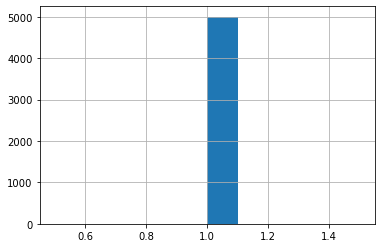

In [229]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist(bins=30)

H L2-error metrics
count    4000.000000
mean        8.807632
std         1.131734
min         5.802072
25%         8.005694
50%         8.676161
75%         9.569152
max        13.294959
dtype: float64


<AxesSubplot:>

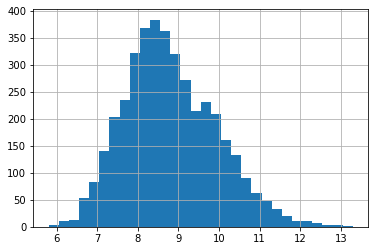

In [231]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
errors = pd.Series(errors)
print("H L2-error metrics")
print(errors.describe())
errors.hist(bins=30)

H L2-error series


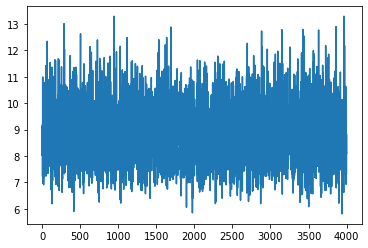

In [232]:
errors.plot()
print("H L2-error series")

## 2.4.1 BDMCMC Sampling

### Task:

You must implement a function that receives matrices $W$, $Z_{i+1}$ and $H_{i+1}$ and generates the next $G_{i+1}$ and $K_{i+1}$.

In [236]:
import subprocess

def serialize_matrix(m):
    if len(m.shape) != 2:
        raise Exception("Can not serialize ill-shaped matrix!")
    res = '\n'.join(' '.join(str(entry) for entry in row)  # Space between entries, newline between rows
                     for row in m)
    return '"' + res + '"'

def deserialize_matrix(line, shape, separator=' '):
    return np.fromstring(line, sep=separator).reshape(shape)


def MC_sample_GK(G, H, degrees_of_freedom_b, debug=False):
    size = G.shape[0]
    n = H.shape[0]
    
    # Serialize the inputs
    G = serialize_matrix(G)
    
    # Transform H into the BDGraph data matrix
    data_matrix = H_sample.T.dot(H_sample)
    data_matrix = serialize_matrix(data_matrix)
    
    # call R script using python.subprocess
    # The parameter order is: deg.of freedom b, 
    #                         number of data samples (documents) n, 
    #                         graph adjacency matrix G, 
    #                         data matrix,
    #                         debug ("TRUE" or "FALSE"), 
    command = f"Rscript --vanilla bdmcmc.R {degrees_of_freedom_b} {n} {G} {data_matrix} {'TRUE' if debug else 'FALSE'}"
    result = subprocess.run(command, 
                            shell=True, 
                            capture_output=True,
                            text=True)
    
    if result.returncode != 0:  # Something went wrong
        print(result.stdout)
        print(result.stderr)
        raise Exception("Rscript error! Check the previous logs for more details")
    
    if debug:
        print(result.stdout)
    
    # The last two lines of the R output MUST be the sampled matrices
    lines = result.stdout.rsplit('\n', 3)  # Split only the last three lines  https://www.w3schools.com/python/ref_string_rsplit.asp
    waiting_time = float(lines[-3])  # 3rd from the end
    G = deserialize_matrix(lines[-2], shape=(size, size))  # Line before last
    K = deserialize_matrix(lines[-1], shape=(size, size))  # Last line
    return waiting_time, G, K

#### MC_sample_G tests

In [247]:
# Check that the function runs with no issues, without side effects
G_copy = random_initial_data.G.copy()
H_copy = test_data.H.copy()
degrees_of_freedom_b = k - 1
shape_matrix = np.eye(k)

wt_sample, G_sample, K_sample = MC_sample_GK(G_copy, H_copy, degrees_of_freedom_b, debug=True)

# assert np.all(W_copy == test_data.W)
# assert np.all(Z_copy == test_data.Z)
# assert np.all(H_copy == test_data.H)
# assert np.all(K_copy == test_data.K)
# assert np.all(E_copy == test_data.E)
# assert np.all(shape_matrix == np.eye(k))

[1] "[R] Matrix G:"
     V1 V2 V3 V4 V5
[1,]  0  0  0  0  0
[2,]  0  0  0  0  0
[3,]  0  0  0  0  0
[4,]  0  0  0  0  0
[5,]  0  0  0  0  0
[1] "[R] Data Matrix:"
             V1        V2         V3         V4         V5
[1,]  7.2968015 -2.420489 -1.4795909 -2.7966846  0.7316807
[2,] -2.4204890  5.299117 -3.9268501  2.3824483 -1.0146214
[3,] -1.4795909 -3.926850  9.0679195 -0.6008072  2.7273701
[4,] -2.7966846  2.382448 -0.6008072  2.6820711 -1.0340785
[5,]  0.7316807 -1.014621  2.7273701 -1.0340785  6.5834584
[1] "[R] Shape Matrix:"
     [,1] [,2] [,3] [,4] [,5]
[1,]    1    0    0    0    0
[2,]    0    1    0    0    0
[3,]    0    0    1    0    0
[4,]    0    0    0    1    0
[5,]    0    0    0    0    1
1 iteration is started.                     
 Iteration  1                 
[1] "[R] Waiting time:"
[1] 0.45
[1] "[R] Sampled Matrix G:"
   V1 V2 V3 V4 V5
V1  0  0  0  0  0
V2  0  0  0  0  0
V3  0  0  0  0  0
V4  0  0  0  0  0
V5  0  0  0  0  0
[1] "[R] Sampled Matrix K:"
      

## 2.4.2 BDMCMC Sampling Tests

#### MC_sample_GK tests

In [249]:
#This is a basic test of MC_sample_GK
G = [[0,0,1,0,0],
     [0,0,0,0,0],
     [1,0,0,0,0],
     [0,0,0,0,0],
     [0,0,0,0,0]]
G = np.array(G)
wt_sample, G_sample, K_sample = MC_sample_GK(G, H_copy, degrees_of_freedom_b, debug=True)

assert np.all(shape_matrix == np.eye(5, dtype=int))

[1] "[R] Matrix G:"
     V1 V2 V3 V4 V5
[1,]  0  0  1  0  0
[2,]  0  0  0  0  0
[3,]  1  0  0  0  0
[4,]  0  0  0  0  0
[5,]  0  0  0  0  0
[1] "[R] Data Matrix:"
             V1        V2         V3         V4         V5
[1,]  7.2968015 -2.420489 -1.4795909 -2.7966846  0.7316807
[2,] -2.4204890  5.299117 -3.9268501  2.3824483 -1.0146214
[3,] -1.4795909 -3.926850  9.0679195 -0.6008072  2.7273701
[4,] -2.7966846  2.382448 -0.6008072  2.6820711 -1.0340785
[5,]  0.7316807 -1.014621  2.7273701 -1.0340785  6.5834584
[1] "[R] Shape Matrix:"
     [,1] [,2] [,3] [,4] [,5]
[1,]    1    0    0    0    0
[2,]    0    1    0    0    0
[3,]    0    0    1    0    0
[4,]    0    0    0    1    0
[5,]    0    0    0    0    1
1 iteration is started.                     
 Iteration  1                 
[1] "[R] Waiting time:"
[1] 0.45
[1] "[R] Sampled Matrix G:"
   V1 V2 V3 V4 V5
V1  0  0  1  0  0
V2  0  0  0  0  0
V3  0  0  0  0  0
V4  0  0  0  0  0
V5  0  0  0  0  0
[1] "[R] Sampled Matrix K:"
      

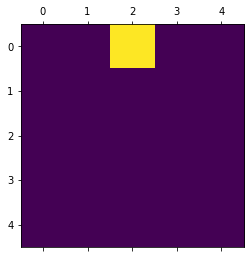

In [313]:
plt.matshow(G_sample)  # Why is this NOT symmetric?

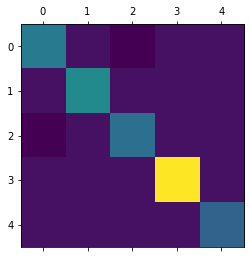

In [314]:
plt.matshow(K_sample)  # Why is this NOT a mask of G?

In [316]:
%%time
# Check that the Sampler works properly (This will take... forever)
K_errors = []
G_errors = []
matrix_changes = []
burn_in = 0
for i in range(1000):
    K_sample_old = K_sample.copy()
    G_sample_old = G_sample.copy()
    wt_sample, G_sample, K_sample = MC_sample_GK(G_sample, H_copy, degrees_of_freedom_b, debug=False)
    matrix_changes.append(~np.all(K_sample_old == K_sample))
    if i >= burn_in:
        K_errors.append(np.linalg.norm(K_sample - test_data.K))  # Computing error wrt the target matrix        
        G_errors.append(np.linalg.norm(G_sample - test_data.K))  # Computing error wrt the target matrix

CPU times: user 784 ms, sys: 4.13 s, total: 4.92 s
Wall time: 3min 56s


Matrix changes (1 = changed, 0 = same)
count    1000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

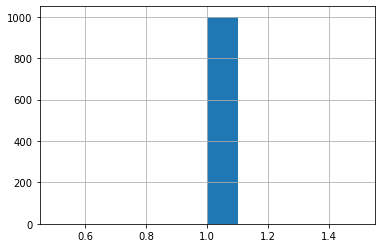

In [317]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

K L2-error metrics
count    4000.000000
mean        8.807632
std         1.131734
min         5.802072
25%         8.005694
50%         8.676161
75%         9.569152
max        13.294959
dtype: float64


<AxesSubplot:>

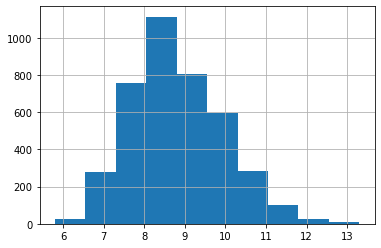

In [318]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
K_errors = pd.Series(errors)
print("K L2-error metrics")
print(K_errors.describe())
K_errors.hist()

K L2-error series


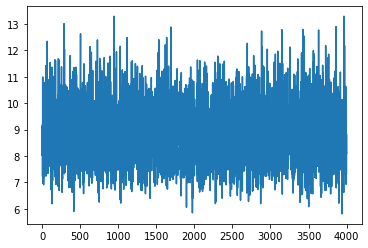

In [319]:
K_errors.plot()
print("K L2-error series")

G L2-error metrics
count    4000.000000
mean        8.807632
std         1.131734
min         5.802072
25%         8.005694
50%         8.676161
75%         9.569152
max        13.294959
dtype: float64


<AxesSubplot:>

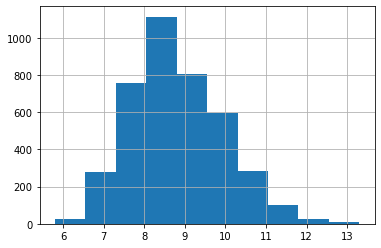

In [320]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
G_errors = pd.Series(errors)
print("G L2-error metrics")
print(G_errors.describe())
G_errors.hist()

G L2-error series


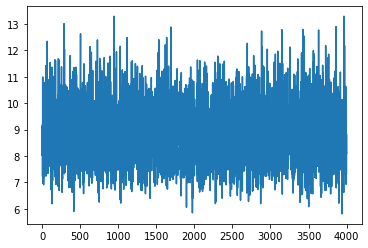

In [321]:
G_errors.plot()
print("G L2-error series")

# MAIN ALGORITHM

### Generating Data

In [326]:
simulated_data = Simulator(D, V, M, k, gamma, seed=1888)
simulated_data.generate_all_data()

Success: Sigma transformed from K
Success: Theta transformed from H
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


In [327]:
# Input Data:
simulated_data.W

array([[ 8., 10.,  0.,  6.,  6.,  4.,  0.,  9.,  5.,  5.,  6.,  3.],
       [ 6.,  7.,  1.,  6., 10., 10.,  0., 10.,  4.,  4.,  4.,  7.],
       [ 0.,  5.,  0.,  2.,  4.,  3.,  0.,  0.,  2.,  0.,  3.,  1.],
       [ 5.,  7.,  1., 10.,  5.,  4.,  0.,  8.,  8.,  4.,  4.,  6.],
       [ 1.,  3.,  0.,  2.,  5.,  3.,  1.,  0.,  2.,  0.,  3.,  6.],
       [ 2.,  7.,  0.,  2.,  5.,  4.,  0.,  6.,  3.,  2.,  5.,  1.],
       [ 6., 10.,  1.,  7.,  7.,  4.,  0.,  7.,  2.,  2.,  6.,  5.],
       [ 8., 10.,  0.,  4.,  8., 10.,  0., 10.,  5.,  3.,  7.,  7.]])

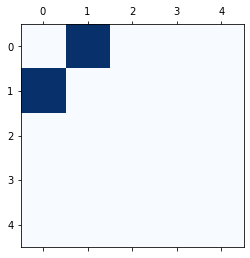

In [328]:
# Target graph
plt.matshow(simulated_data.G, cmap='Blues')

# SAMPLER

In [329]:
# # Initial guesses
initial = Simulator(D, V, M, k, gamma, 2020)
initial.sample_GK()
initial.sample_B()
initial.sample_H()

Success: Sigma transformed from K
Success: Theta transformed from H


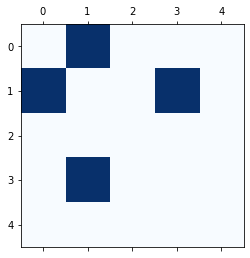

In [337]:
# Initial graph
plt.matshow(initial.G, cmap='Blues')

Success: E transformed from Z
Success: C transformed from Z


/tmp/ipykernel_39721/2545393832.py:6: RuntimeWarning: overflow encountered in exp
  return np.exp(eta_K_eta + E_eta) / sum_eta_pow_k  # This np.exp raises a warning when  eta_K_eta + E_eta > 706


At iteration 0, the wrong edges are 2 and the error on Sigma is 0.7201932254880481


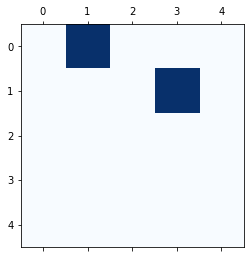

G matrix has NOT changed!
At iteration 1, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT changed!
At iteration 2, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT changed!
At iteration 3, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT changed!
At iteration 4, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT changed!
At iteration 5, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT changed!
At iteration 6, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT changed!
At iteration 7, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT changed!
At iteration 8, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT changed!
At iteration 9, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT ch

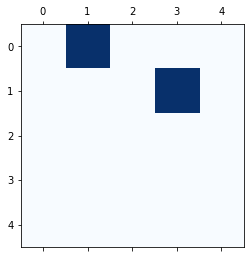

G matrix has NOT changed!
At iteration 11, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT changed!
At iteration 12, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT changed!
At iteration 13, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT changed!
At iteration 14, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT changed!
At iteration 15, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT changed!
At iteration 16, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT changed!
At iteration 17, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT changed!
At iteration 18, the wrong edges are 2 and the error on Sigma is 0.7201932254880481
G matrix has NOT changed!
At iteration 19, the wrong edges are 2 and the error on Sigma is 0.7201932254880481


In [342]:
max_iteration = 20

# Initialization
Sigma = initial.Sigma
K = np.linalg.inv(Sigma)
B = initial.B
Theta = initial.Theta
G = initial.G

alpha = np.ones(V)  # Uninformative prior
b = k - 1

Z = sample_Z_from_W(simulated_data.W.astype(int), k, 2020)  # Random sample of Z based on actual data

E = update_E(np.zeros((D, k)), Z)  # Transformation of Z
C = update_C(np.zeros((k, V)), Z)  # Transformation of Z


for iteration in range(max_iteration):
    
    # Step 1
    Z, E, C = MC_sample_Z(Z, simulated_data.W, Theta, B, E, C) 
    
    # Step 2
    B = MC_sample_B(alpha, C)
    
    # Step 3
    H = MC_sample_H(E, Sigma)
    Theta = update_Theta(Theta, H)  # get Theta from H
    
    # Step 4    
    G_old = G.copy()
    wt_sample, G_new, K = MC_sample_GK(G, H, b, debug=False)
    if np.all(G_new == G_old):
        print('G matrix has NOT changed!')
    G = G_new
    
    # Hope for convergence!
    wrong_edges = np.sum(G != simulated_data.G)
    error = np.linalg.norm(Sigma - simulated_data.Sigma)
    print(f"At iteration {iteration}, the wrong edges are {wrong_edges} and the error on Sigma is {error}")
    
    if iteration%10==0:  # Plot every 10 iterations
        plt.matshow(G, cmap='Blues')
        plt.show()